In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpyro
#import arviz as az
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import ImproperUniform, LKJCholesky
from numpyro.distributions import constraints
from numpyro.handlers import substitute, trace

numpyro.enable_x64()  # meant to improve performance

import time, datetime, os

import seaborn as sns
import matplotlib.pyplot as plt

## Simulate some data:

/Users/victorlhoste/opt/anaconda3/envs/bayesian2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


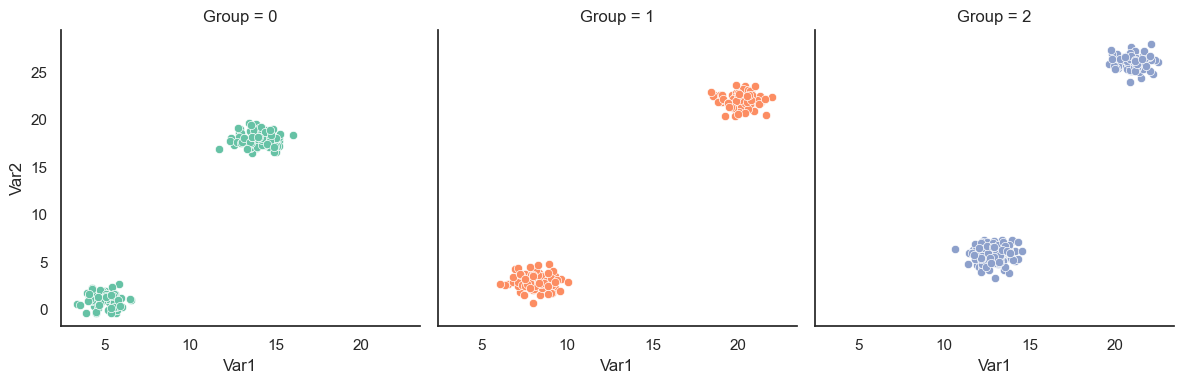

In [12]:
def generate_mixture_data(n, mixtures):
    data = np.zeros((n, 2))
    
    for i in range(n):
        # Choose the component based on the given mixture probabilities
        component = np.random.choice(len(mixtures), p=[m[0] for m in mixtures])
        # Random sample from the chosen component
        mean = mixtures[component][1]
        data[i, :] = np.random.multivariate_normal(mean, 0.5*np.eye(2))
    
    return data

# Generate data for each group
group1_data = generate_mixture_data(200, [(0.3, [5, 1]), (0.7, [14, 18])])
group2_data = generate_mixture_data(200, [(0.5, [8, 3]), (0.5, [20, 22])])
group3_data = generate_mixture_data(200, [(0.6, [13, 6]), (0.4, [21, 26])])

# Combine data into a single DataFrame
data = np.vstack((group1_data, group2_data, group3_data))
df = pd.DataFrame(data, columns=['Var1', 'Var2'])

# Add group labels
df['Group'] = [0]*200 + [1]*200 + [2]*200

sns.set(style="white")

# Create a FacetGrid
g = sns.FacetGrid(df, col="Group", hue="Group", col_wrap=3, height=4, palette="Set2")
g.map_dataframe(sns.scatterplot, x='Var1', y='Var2')
g.set_axis_labels("Var1", "Var2")

plt.show()

In [13]:
def Model_HGMM(K=2, dimension=2, data=None, label=None):
    l = len(np.unique(label))

    with numpyro.plate("components", K):
        locs = numpyro.sample(
            "locs",
            dist.MultivariateNormal(jnp.zeros(dimension), 10 * jnp.eye(dimension)),
        )
        sigma = numpyro.sample("sigma", dist.LKJ(dimension, concentration=1))
        
    with numpyro.plate("dimension", dimension):
        with numpyro.plate("components", K):
            with numpyro.plate("Age group", l):
                locs_perturb = numpyro.sample(
                 "locs_perturb",
                    dist.Normal(loc=0,scale=0.1), 
            )
    with numpyro.plate("Age group", l):
        cluster_proba = numpyro.sample(
            "cluster_proba", dist.Dirichlet(jnp.ones(K))
        )

    
    print("locs shape",locs.shape)
    print("locs_perturb shape",locs_perturb.shape)
    print("sigma shape",sigma.shape)

    with numpyro.plate("data", len(data)):
        assignment = numpyro.sample(
            "assignment",
            dist.Categorical(cluster_proba[label]),
            infer={"enumerate": "parallel"},
        )
        print("locs[assignment] shape",locs[assignment].shape)
        print("locs_perturb[label, assignment, :] shape",locs_perturb[label, assignment, :].shape)
        print("sigma[assignment] shape",sigma[assignment].shape)

        numpyro.sample(
            "obs",
            dist.MultivariateNormal(
                locs[assignment] + locs_perturb[label, assignment, :],
                covariance_matrix=sigma[assignment],
            ),
            obs=data,
        )

In [16]:
kernel = NUTS(Model_HGMM)
num_warmup, num_samples = 500, 1000
n_clusters=2
n_variables=2
data=df[["Var1","Var2"]].to_numpy()
label=df[["Group"]].to_numpy().flatten()
mcmc = MCMC(  ## I could actually run several chains here and group by chains
        kernel, num_warmup=num_warmup, num_samples=num_samples
    )

rng_key = jax.random.PRNGKey(10)
mcmc.warmup(rng_key,collect_warmup=True,K=n_clusters,
        dimension=n_variables,
        data=data,
        label=label)
mcmc.run(
        rng_key,
        K=n_clusters,
        dimension=n_variables,
        data=data,
        label=label
 
    )

locs shape (2, 2)
locs_perturb shape (3, 2, 2)
sigma shape (2, 2, 2)
locs[assignment] shape (600, 2)
locs_perturb[label, assignment, :] shape (600, 2)
sigma[assignment] shape (600, 2, 2)
locs shape (2, 2)
locs_perturb shape (3, 2, 2)
sigma shape (2, 2, 2)
locs[assignment] shape (2, 1, 1, 1, 2)
locs_perturb[label, assignment, :] shape (2, 1, 1, 600, 2)
sigma[assignment] shape (2, 1, 1, 1, 2, 2)


  0%|          | 0/500 [00:00<?, ?it/s]

locs shape (2, 2)
locs_perturb shape (3, 2, 2)
sigma shape (2, 2, 2)
locs[assignment] shape (2, 1, 1, 1, 2)
locs_perturb[label, assignment, :] shape (2, 1, 1, 600, 2)
sigma[assignment] shape (2, 1, 1, 1, 2, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

locs shape (2, 2)
locs_perturb shape (3, 2, 2)
sigma shape (2, 2, 2)
locs[assignment] shape (2, 1, 1, 1, 2)
locs_perturb[label, assignment, :] shape (2, 1, 1, 600, 2)
sigma[assignment] shape (2, 1, 1, 1, 2, 2)


sample: 100%|██████████| 1000/1000 [00:08<00:00, 112.97it/s, 15 steps of size 2.94e-01. acc. prob=0.92]


<bound method MCMC.print_summary of <numpyro.infer.mcmc.MCMC object at 0x7fd8b5b85f00>>

In [17]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
 cluster_proba[0,0]      0.65      0.03      0.65      0.59      0.69   1868.45      1.00
 cluster_proba[0,1]      0.35      0.03      0.35      0.31      0.41   1868.45      1.00
 cluster_proba[1,0]      0.48      0.03      0.48      0.43      0.54   2090.88      1.00
 cluster_proba[1,1]      0.52      0.03      0.52      0.46      0.57   2090.88      1.00
 cluster_proba[2,0]      0.39      0.04      0.39      0.33      0.45   2221.93      1.00
 cluster_proba[2,1]      0.61      0.04      0.61      0.55      0.67   2221.93      1.00
          locs[0,0]     17.98      0.08     17.98     17.86     18.11    874.27      1.00
          locs[0,1]     21.63      0.08     21.63     21.51     21.77    903.39      1.00
          locs[1,0]      9.06      0.08      9.06      8.93      9.20    934.44      1.00
          locs[1,1]      3.61      0.08      3.62      3.49      3.77    993.06      1.00
locs_pert

locs shape (2, 2)
locs_perturb shape (3, 2, 2)
sigma shape (2, 2, 2)
locs[assignment] shape (600, 2)
locs_perturb[label, assignment, :] shape (600, 2)
sigma[assignment] shape (600, 2, 2)


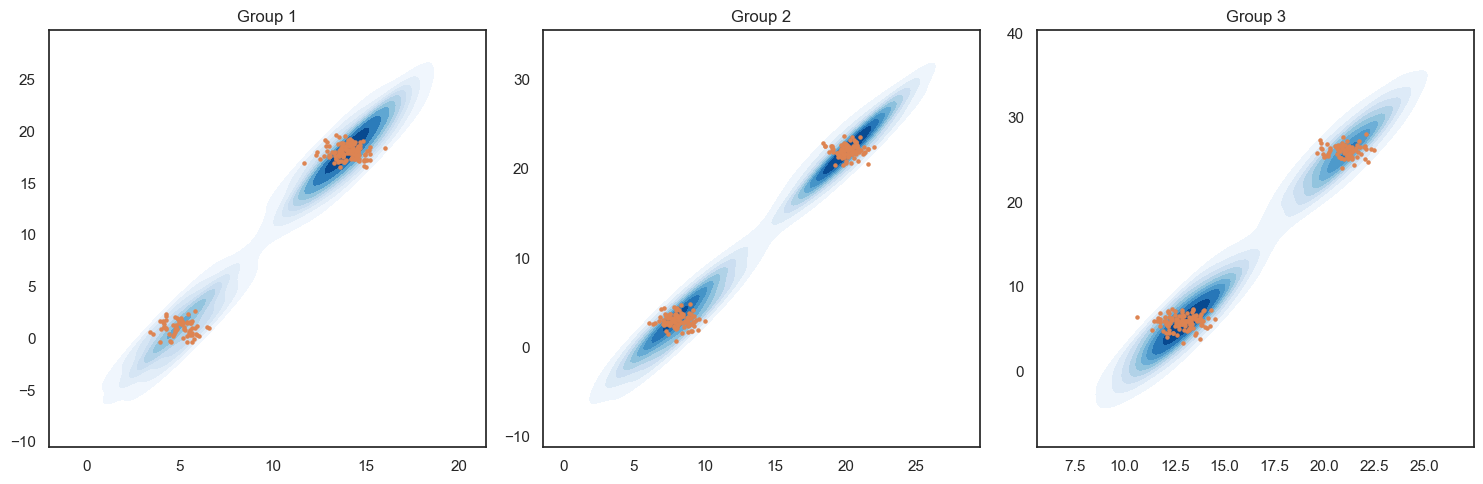

In [18]:
# Generate new samples using Predictive
predictive = Predictive(Model_HGMM, mcmc.get_samples())
rng_key, _ = jax.random.split(rng_key)
simulated_data = predictive(rng_key, K=n_clusters, dimension=n_variables, data=data, label=label)

# Plot the simulated data
plt.figure(figsize=(15, 5))
for group in range(3):
    ax = plt.subplot(1, 3, group + 1)
    data_group = simulated_data['obs'][-1][label == group]  # Select data for the last iteration
    sns.kdeplot(x=data_group[:, 0], y=data_group[:, 1], fill=True, cmap="Blues", ax=ax)
    ax.scatter(data_group[:, 0], data_group[:, 1], s=5)
    ax.set_title(f'Group {group+1}')
plt.tight_layout()
plt.show()

In [19]:
mcmc_samples = mcmc.get_samples()  # Assuming you've run MCMC already

# Condition the model on the MCMC samples
conditioned_model = substitute(Model_HGMM, mcmc_samples)

# Now trace the conditioned model
traced_model = trace(conditioned_model).get_trace(K=2, dimension=2, data=data, label=label)
log_likelihood = traced_model['obs']['fn'].log_prob(traced_model['obs']['value'])

locs shape (1000, 2, 2)
locs_perturb shape (1000, 3, 2, 2)
sigma shape (1000, 2, 2, 2)


ValueError: Incompatible shapes for broadcasting: shapes=[(600,), (600, 3)]